<a href="https://colab.research.google.com/github/YangJiao85/PANDA-kaggle/blob/master/panda_pngtiles_model1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PANDA: start from tiles in png zip file

This notebook got inspirations from
- [PANDA 16X128X128 tiles from Iafoss](https://www.kaggle.com/iafoss/panda-16x128x128-tiles) 

Thank you for sharing!

This note book extracts tiles from original images and save them as dataset panda-tile-ntxnrxnr.

Set some parameters.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
""" PATH on kaggle
DATA_PATH     = '/kaggle/input/prostate-cancer-grade-assessment/'
TRAIN_PATH    = DATA_PATH + 'train_images/'
MASKS_PATH    = DATA_PATH + 'train_label_masks/'
TEST_PATH     = DATA_PATH + 'test_images/'
MODEL_PATH    = './'                                       # path to save model
ENET_MODEL_PATH = '/kaggle/input/efficientnettf/'          # pretrained model from efficientnet package
restart_path  = '/kaggle/input/panda-modelweights/model_v1.0.h5'
"""
""" PATH on Colab """
Colab_ROOT    = '/content/drive/My Drive/Colab Notebooks/competetions/'
DATA_PATH     = Colab_ROOT + 'input/prostate-cancer-grade-assessment/'
TRAIN_PATH    = DATA_PATH + 'train_images/'
MASKS_PATH    = DATA_PATH + 'train_label_masks/'
TEST_PATH     = DATA_PATH + 'test_images/'
TRAIN_TILES_PATH = DATA_PATH + 'train_images_tiles16x128x128'
MASKS_TILES_PATH = DATA_PATH + 'train_masks_tiles16x128x128'
MODEL_PATH    = Colab_ROOT + 'PANDA/'                       # path to save model
ENET_MODEL_PATH = './'                                       # pretrained model from efficientnet package
restart_path  = MODEL_PATH + 'model_v1.1.h5'

MODEL_VERSION = 'v1.2_png'                                     # version for the model to be saved
restart       = True
EPOCHS        = 10
TILE_SIZE     = 128      # 16 128x128 tiles are selected from each image and mask
NUM_TILE      = 16
BATCH_SIZE    = 4
INI_LR        = 1.e-4

SEED          = 2020

Update to TensorFlow 2.2.0 and TensorFlow-Addons 0.10.0.
- CohenKappa metric and WeightedKappaLoose are used as implemented in TensorFlow Addons 0.10.0.

In [3]:
import sys
print('Python {}'.format(sys.version))
print(sys.version_info)

Python 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


In [4]:
import tensorflow as tf
print('tensorflow version:  {}'.format(tf.__version__))

tensorflow version:  2.2.0


In [5]:
!pip install --quiet tensorflow_addons==0.10.0
!pip install --quiet efficientnet==1.1.0
!pip install --quiet memory_profiler

     |████████████████████████████████| 1.1MB 2.8MB/s 


In [6]:
!pip install --quiet imagecodecs

     |████████████████████████████████| 17.9MB 39.3MB/s 


Check TensorFlow and TensorFlow-Addons version.

In [7]:
import tensorflow as tf
import tensorflow_addons as tfa
print('TensorFlow version:        {}'.format(tf.__version__))
print('TensorFlow-Addons version: {}'.format(tfa.__version__))

TensorFlow version:        2.2.0
TensorFlow-Addons version: 0.10.0


Load essential modules. 

In [8]:
import numpy as np
import pandas as pd
import tensorflow.keras as K
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import albumentations as albu      # a fast image augmentation library

import skimage.io
import json

from tensorflow.keras import Model, Sequential
import efficientnet.tfkeras as efn

import os
import memory_profiler


Check GPUs availability. 

In [9]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    logical_gpus = tf.config.list_logical_devices('GPU')
    print('{} Physical GPUs, {} Logical GPUs'.format(len(gpus), len(logical_gpus)))

1 Physical GPUs, 1 Logical GPUs


In [10]:
cpus = tf.config.list_physical_devices('CPU')
if cpus:
    logical_cpus = tf.config.list_logical_devices('CPU')
    print('{} Physical CPUs, {} Logical CPUs'.format(len(cpus), len(logical_cpus)))

1 Physical CPUs, 1 Logical CPUs


In [11]:
os.listdir(DATA_PATH)

['sample_submission.csv',
 'test.csv',
 'train.csv',
 'train_images',
 'train_label_masks',
 'train_images_tiles16x128x128',
 'train_masks_tiles16x128x128']

## Tiles of image

Load whole slide image(WSI), and select 16 128x128 tiles from each image according to the number of tissure pixels.

In [12]:
def tile(img_id, mode = 'train', mask = False, tile_size = 128, num_tile = 16, aug = None):
    # This function selects <num_tile> tiles of size <tile_size>x<tile_size> 
    # for image of <img_id> (and mask) 
    # based on the maximum number of tissue pixels.
    if(mode == 'train'):
        img = skimage.io.MultiImage(os.path.join(TRAIN_PATH, img_id + '.tiff'))[-1] 
    elif(mode == 'test'):
        img = skimage.io.MultiImage(os.path.join(TEST_PATH, img_id + '.tiff'))[-1]
    else:
        raise AttributeError('tile mode Error')
    if aug:
        img = aug(image=img)['image']
    shape = img.shape
    pad0, pad1 = (tile_size - shape[0]%tile_size)%tile_size, (tile_size - shape[1]%tile_size)%tile_size
    img = np.pad(img, [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2], [0,0]],
                 constant_values = 255)
    img = img.reshape(img.shape[0]//tile_size, tile_size, img.shape[1]//tile_size, tile_size,3)
    img = img.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size, 3)
    if len(img) < num_tile:
        img = np.pad(img, [[0, num_tile - len(img)], [0, 0], [0, 0], [0, 0]], 
                     constant_values = 255)    
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_tile]
    img = np.array(img[idxs])
    
    if(mask):
        mask = skimage.io.MultiImage(os.path.join(MASKS_PATH, img_id + '_mask.tiff'))[-1]
        if aug: 
            mask = aug(image=mask)['image']
        if(mask.shape != shape):
            print(f'ID {img_id} image shape {shape} mask shape {mask.shape}')
            mask = np.zeros_like(img)
            return img, mask
        mask = np.pad(mask, [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2], [0,0]],
                      constant_values = 0)
        mask = mask.reshape(mask.shape[0]//tile_size, tile_size, mask.shape[1]//tile_size, tile_size,3)
        mask = mask.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size, 3)
        if len(mask) < num_tile:
            mask = np.pad(mask, [[0, num_tile - len(mask)], [0, 0], [0, 0], [0, 0]], 
                          constant_values = 0)
        mask = np.array(mask[idxs])
        return img, mask
    else:
        return img
    
def glue_to_one(tile_seq):
    l_tile = int(math.sqrt(NUM_TILE))
    img_glue = np.zeros((l_tile*TILE_SIZE, l_tile*TILE_SIZE, 3),
                         dtype = np.float32)
    for i, t in enumerate(tile_seq):
        x = i//l_tile
        y = i%l_tile
        img_glue[x*TILE_SIZE:(x+1)*TILE_SIZE,
                 y*TILE_SIZE:(y+1)*TILE_SIZE, :] = t
    return img_glue

In [13]:
class PANDA_Sequence(Sequence):
    def __init__(self, df, batch_size=16, mode='fit', shuffle = False, aug = None, 
                 num_tile = 16, tile_size = 128, n_classes=6):
        self.df = df            # data frame with the image_id
        self.batch_size = batch_size
        self.mode = mode
        self.shuffle = shuffle
        self.aug = aug
        self.tile_size = tile_size
        self.num_tile = num_tile
        self.n_classes = n_classes
        self.l_tile = int(math.sqrt(self.num_tile))
        if(self.mode == 'fit'):
            self.tile_mode = 'train'
            self.tile_mask = False
        elif(self.mode == 'validate'):
            self.tile_mode = 'train'
            self.tile_mask = False
        elif(self.mode == 'predict'):
            self.tile_mode = 'test'
            self.tile_mask = False
        else:
            raise AttributeError('Sequence mode Error')
        self.on_epoch_end()
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        X = np.zeros((self.batch_size, self.l_tile*self.tile_size, self.l_tile*self.tile_size, 3), dtype = np.float32)
        img_batch = self.df[index*self.batch_size : (index+1)*self.batch_size]['image_id'].values
        for i, img_id in enumerate(img_batch):
            img_tiles = tile(img_id, mode = self.tile_mode, mask = self.tile_mask, tile_size = self.tile_size,
                             num_tile = self.num_tile, aug = self.aug)
            X[i,] = glue_to_one(img_tiles)/255.
        if self.mode in ['fit', 'validate']:
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.float32)
            # encode label list
            lbls_batch = self.df[index * self.batch_size: (index+1) * self.batch_size]['isup_grade'].values
            for i in range(self.batch_size):
                y[i, lbls_batch[i]] = 1
            return X, y
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('mode parameter error')        

## Load data

In [14]:
print('Memory usage : {} MB'.format(*memory_profiler.memory_usage(-1)))

Memory usage : 954.8359375 MB


In [15]:
df_train = pd.read_csv('{}/train.csv'.format(DATA_PATH))
print('train: {}'.format(df_train.shape))
print('unique isup grade: {}'.format(df_train['isup_grade'].nunique()))

# train_image is partly uploaded
tiff_uploaded = df_train['image_id'].apply(lambda x: os.path.isfile(os.path.join(TRAIN_PATH, x+'.tiff')))
df_train = df_train[tiff_uploaded]
print('train: {}'.format(df_train.shape))
print('unique isup grade: {}'.format(df_train['isup_grade'].nunique()))

X_train, X_val = train_test_split(df_train, test_size = .2, stratify=df_train['isup_grade'],
                                  random_state = SEED)
lbl_value_counts = X_train['isup_grade'].value_counts()
class_weights = {i: max(lbl_value_counts)/v for i, v in lbl_value_counts.items()}
print('classes weights: {}'.format(class_weights))
print('Memory usage : {} MB'.format(*memory_profiler.memory_usage(-1)))

train: (10616, 4)
unique isup grade: 6
train: (10616, 4)
unique isup grade: 6
classes weights: {0: 1.0, 1: 1.0843881856540085, 2: 2.153631284916201, 4: 2.315315315315315, 3: 2.3269617706237424, 5: 2.362614913176711}
Memory usage : 965.1484375 MB


Augmentation

In [16]:
aug = albu.Compose([
    albu.OneOf([albu.RandomBrightness(limit=.15),
                albu.RandomContrast(limit=.3),
                albu.RandomGamma()], p=.25),
    albu.HorizontalFlip(p=.25),
    albu.VerticalFlip(p=.25),
    albu.ShiftScaleRotate(shift_limit = .1,
                          scale_limit=.1,
                          rotate_limit = 20,
                          p=.25)
])

## Load images composed of tiles

In [17]:
%%time
!pip install pygame

     |████████████████████████████████| 11.4MB 270kB/s 
CPU times: user 39.4 ms, sys: 27.6 ms, total: 67 ms
Wall time: 6.57 s


In [18]:
import zipfile
from tqdm.notebook import tqdm    # A Fast, Extensible Progress Bar 
                                  # for Python and CLI 
import cv2
import binascii
import io
import pygame                     # a Python wrapper module for the SDL multimedia library

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [19]:
ZIP_TRAIN = os.path.join(TRAIN_TILES_PATH, 'train.zip')
ZIP_MASKS = os.path.join(MASKS_TILES_PATH, 'masks.zip') 

(512, 512, 3)
(512, 512)


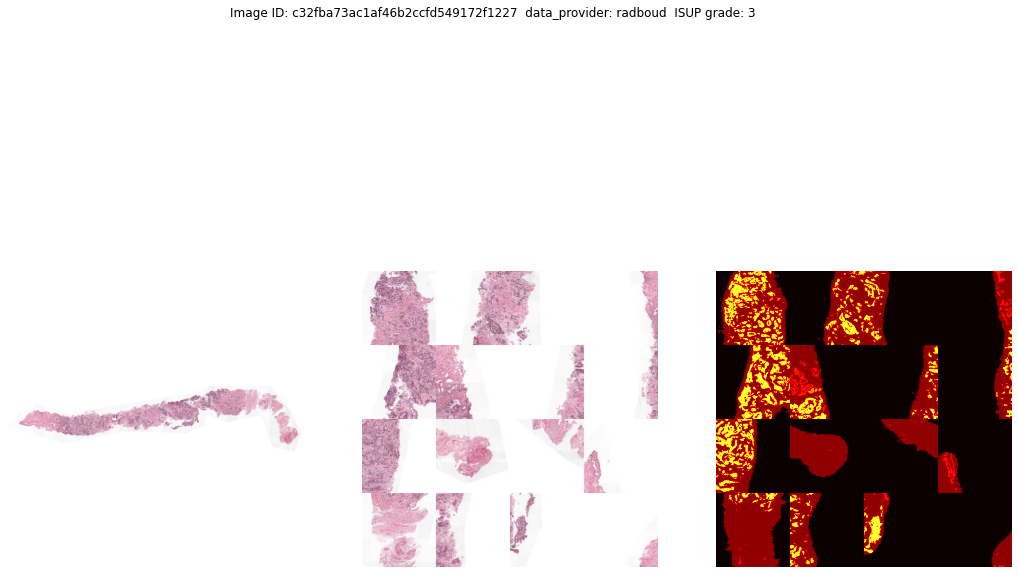

In [20]:
# Check the tiles png files
def plot_tiles_png(img_id):
    img = skimage.io.MultiImage(os.path.join(TRAIN_PATH, img_id + '.tiff'))[-1]
    
    archive_img = zipfile.ZipFile(ZIP_TRAIN, 'r')
    data_img = archive_img.read(img_id + '_tiles.png')
    bytes_io = io.BytesIO(data_img)
    img_tiles = pygame.image.load(bytes_io)
    img_tiles = pygame.surfarray.array3d(img_tiles)
    print(img_tiles.shape)

    archive_mask = zipfile.ZipFile(ZIP_MASKS, 'r')
    data_mask = archive_mask.read(img_id + '_mask_tiles.png')
    bytes_io = io.BytesIO(data_mask)
    mask_tiles = pygame.image.load(bytes_io)
    mask_tiles = pygame.surfarray.array2d(mask_tiles)
    print(mask_tiles.shape)
        
    fig, ax = plt.subplots(1, 3, figsize=(18,12))
    fig.suptitle('Image ID: {}  data_provider: {}  ISUP grade: {}'.format(img_id, 
                                 df_train[df_train['image_id']==img_id]['data_provider'].values[0],
                                 df_train[df_train['image_id']==img_id]['isup_grade'].values[0]))
    ax[0].imshow(img)
    ax[1].imshow(img_tiles)
    ax[2].imshow(mask_tiles, cmap = 'hot', vmin = 0, vmax = 5)
    for i in range(3):
        ax[i].axis('off')
    plt.show()
    return
    
img_id = df_train[df_train['isup_grade']==3]['image_id'].sample(n=1, random_state = SEED).to_numpy()[0]
plot_tiles_png(img_id)

In [21]:
class PANDA_tile_Sequence(Sequence):
    def __init__(self, df, batch_size=16, mode='fit', shuffle = False, aug = None, 
                 num_tile = 16, tile_size = 128, n_classes=6):
        self.df = df            # data frame with the image_id
        self.batch_size = batch_size
        self.mode = mode
        self.shuffle = shuffle
        self.aug = aug
        self.tile_size = tile_size
        self.num_tile = num_tile
        self.n_classes = n_classes
        self.l_tile = int(math.sqrt(self.num_tile))
        if(self.mode == 'fit'):
            self.tile_mode = 'train'
            self.tile_mask = False
        elif(self.mode == 'validate'):
            self.tile_mode = 'train'
            self.tile_mask = False
        elif(self.mode == 'predict'):
            self.tile_mode = 'test'
            self.tile_mask = False
        else:
            raise AttributeError('Sequence mode Error')
        self.on_epoch_end()
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        X = np.zeros((self.batch_size, self.l_tile*self.tile_size, self.l_tile*self.tile_size, 3), dtype = np.float32)
        img_batch = self.df[index*self.batch_size : (index+1)*self.batch_size]['image_id'].values
        if self.tile_mode == 'train':
            archive_img = zipfile.ZipFile(ZIP_TRAIN, 'r')
            for i, img_id in enumerate(img_batch):
                data_img = archive_img.read(img_id + '_tiles.png')
                bytes_io = io.BytesIO(data_img)
                img_tiles = pygame.image.load(bytes_io)
                X[i,] = pygame.surfarray.array3d(img_tiles)/255.
        else:
            for i, img_id in enumerate(img_batch):
                img_tiles = tile(img_id, mode = self.tile_mode, mask = self.tile_mask, tile_size = self.tile_size,
                                 num_tile = self.num_tile, aug = self.aug)
                X[i,] = glue_to_one(img_tiles)/255.
        if self.mode in ['fit', 'validate']:
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.float32)
            # encode label list
            lbls_batch = self.df[index * self.batch_size: (index+1) * self.batch_size]['isup_grade'].values
            for i in range(self.batch_size):
                y[i, lbls_batch[i]] = 1
            return X, y
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('mode parameter error')        

In [22]:
train_gen = PANDA_tile_Sequence(
    df = X_train,
    batch_size = BATCH_SIZE,
    mode = 'fit',
    shuffle = False,
    aug = None,
    num_tile = NUM_TILE,
    tile_size = TILE_SIZE,
    n_classes = 6)

val_gen = PANDA_tile_Sequence(
    df = X_val,
    batch_size = BATCH_SIZE,
    mode = 'validate',
    shuffle = False,
    aug = None,
    num_tile = NUM_TILE,
    tile_size = TILE_SIZE,
    n_classes = 6)


test X: (4, 512, 512, 3)
test y: (4, 6)


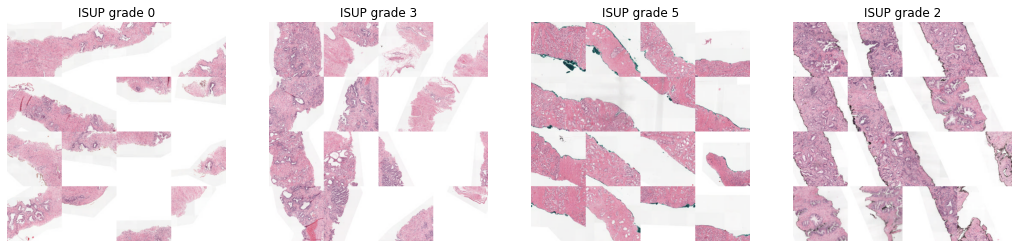

Memory usage : 1028.8359375 MB


In [23]:
Xt, yt = train_gen.__getitem__(0)
print('test X: {}'.format(Xt.shape))
print('test y: {}'.format(yt.shape))
fig, axes = plt.subplots(ncols = BATCH_SIZE, figsize=(18, 18))
for j in range(BATCH_SIZE):
    axes[j].imshow(Xt[j])
    axes[j].axis('off')
    axes[j].set_title('ISUP grade {}'.format(np.argmax(yt[j,])))
plt.show()
print('Memory usage : {} MB'.format(*memory_profiler.memory_usage(-1)))

## Model

Model based on EfficientNetB3:

In [24]:
def get_uncompiled_model():
    conv_base = efn.EfficientNetB3(
        input_shape = (int(math.sqrt(NUM_TILE))*TILE_SIZE, int(math.sqrt(NUM_TILE))*TILE_SIZE, 3),
        weights = 'imagenet',   #os.path.join(ENET_MODEL_PATH, 
                                #'efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'),  # pretrained weights with ImageNet
        include_top = False,
        pooling = 'avg')
    conv_base = K.Model(inputs=conv_base.inputs, outputs=conv_base.outputs)
    model = Sequential()
    model.add(conv_base)
    #model.add(K.layers.Dropout(.2))
    model.add(K.layers.Dense(6, activation='softmax'))
    conv_base.trainable = False
    
    if restart:
        #model.load_weights(restart_path, by_name = True, skip_mismatch = True)
        #print('model weights loaded')
        # set more layers trainable
        conv_base.trainable = True
        set_trainable = False
        for layer in conv_base.layers:
            if layer.name == 'block7b_add':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False
        model.load_weights(restart_path, by_name = True, skip_mismatch = True)
        print('model weights loaded')
    else:
        print('train from scratch')

    return model

def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer = K.optimizers.Adam(lr=INI_LR),
        loss = tfa.losses.WeightedKappaLoss(num_classes=6, weightage='quadratic'),
        metrics = ['categorical_accuracy', tfa.metrics.CohenKappa(num_classes=6, weightage='quadratic')]
        )
    return model

In [25]:
model = get_compiled_model()
print('Memory usage : {} MB'.format(*memory_profiler.memory_usage(-1)))

44113920/44107200 [==============================] - 4s 0us/step
model weights loaded
Memory usage : 1174.60546875 MB


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 1536)              10783528  
_________________________________________________________________
dense (Dense)                (None, 6)                 9222      
Total params: 10,792,750
Trainable params: 602,118
Non-trainable params: 10,190,632
_________________________________________________________________


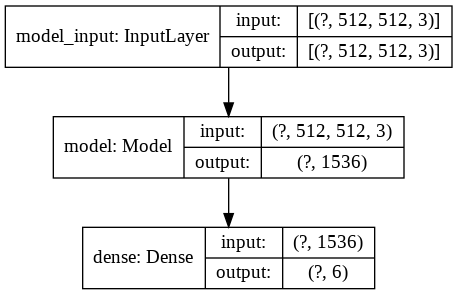

In [27]:
K.utils.plot_model(model, show_shapes=True)

Plot of the top layers from EfficientNetB3 base model. Layer 'block7b_add' and above layers are trained. Lower layers are fixed at 'ImageNet' weights.  

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.783993 to fit



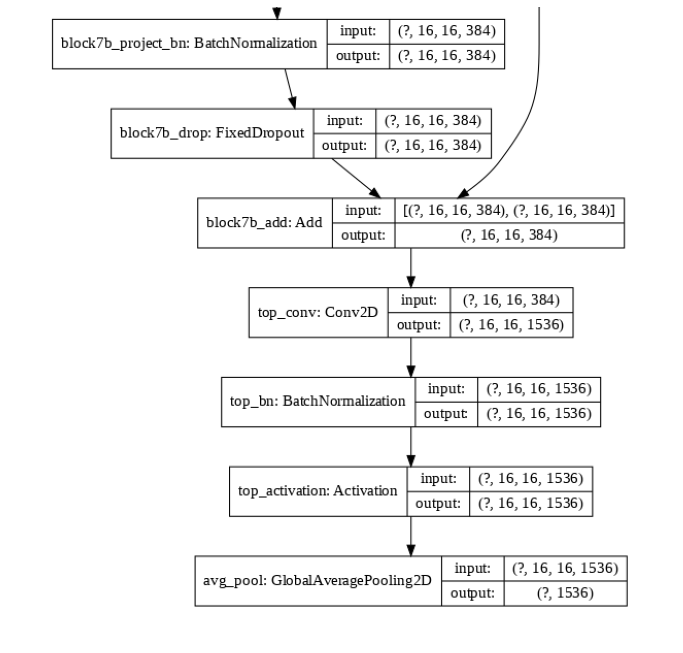

In [28]:
conv_base = efn.EfficientNetB3(
        input_shape = (int(math.sqrt(NUM_TILE))*TILE_SIZE, int(math.sqrt(NUM_TILE))*TILE_SIZE, 3),
        weights = 'imagenet',   #os.path.join(ENET_MODEL_PATH, 
                                #'efficientnet-b3_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'),  # pretrained weights with ImageNet
        include_top = False,
        pooling = 'avg')

_ = K.utils.plot_model(conv_base, to_file = 'model_ENetB3_notop.png', show_shapes=True)
im = plt.imread('model_ENetB3_notop.png')
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ax.imshow(im)
ax.set_xlim(200,850)
ax.set_ylim(32800,32180)
ax.axis('off')
plt.show()

## Train the model

In [29]:
%%time
model_file = '{}/model_{}.h5'.format(MODEL_PATH, MODEL_VERSION)
earlystopper = K.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1,
    mode = 'min'
)
modelsaver = K.callbacks.ModelCheckpoint(
    model_file,
    monitor = 'val_loss',
    verbose = 1,
    save_weights_only = True,
    save_best_only = True,
    mode = 'min'
)
lrreducer = K.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = .1,
    patience = 5,
    verbose = 1,
    min_lr = 1.e-7
)

class mem_use(K.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs=None):
        mem_usage = memory_profiler.memory_usage(-1)
        format_str = 'Memory usage at epoch {:8d}: ' + '{:8.0f}'*len(mem_usage) + ' MB'
        print(format_str.format(epoch, *mem_usage))
        


history = model.fit(
    train_gen,
    validation_data = val_gen,
    class_weight = class_weights,
    callbacks = [earlystopper, modelsaver, lrreducer, mem_use()],
    epochs = EPOCHS,
    verbose = 1
    )


Epoch 1/10
2123/2123 [==============================] - ETA: 0s - loss: -1.8045 - categorical_accuracy: 0.3577 - cohen_kappa: 0.4983
Epoch 00001: val_loss improved from inf to -1.05731, saving model to /content/drive/My Drive/Colab Notebooks/competetions/PANDA//model_v1.2_png.h5
Memory usage at epoch        0:     3055 MB
2123/2123 [==============================] - 916s 431ms/step - loss: -1.8045 - categorical_accuracy: 0.3577 - cohen_kappa: 0.4983 - val_loss: -1.0573 - val_categorical_accuracy: 0.3790 - val_cohen_kappa: 0.5439 - lr: 1.0000e-04
Epoch 2/10
2123/2123 [==============================] - ETA: 0s - loss: -1.8142 - categorical_accuracy: 0.3642 - cohen_kappa: 0.5057
Epoch 00002: val_loss improved from -1.05731 to -1.10910, saving model to /content/drive/My Drive/Colab Notebooks/competetions/PANDA//model_v1.2_png.h5
Memory usage at epoch        1:     3075 MB
2123/2123 [==============================] - 637s 300ms/step - loss: -1.8142 - categorical_accuracy: 0.3642 - cohen_kap

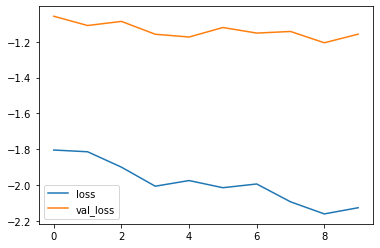

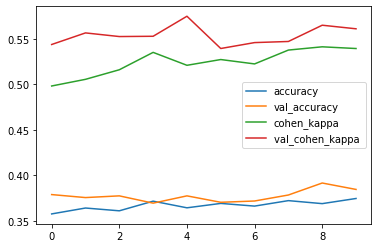

In [30]:
history_file = 'history_{}.txt'.format(MODEL_VERSION)
dict_to_save = {}
for k, v in history.history.items():
    dict_to_save.update({
        k: [np.format_float_positional(x) for x in history.history[k]]
    })
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)
ep_max = EPOCHS
plt.plot(history.history['loss'][:ep_max], label='loss')
plt.plot(history.history['val_loss'][:ep_max], label='val_loss')
plt.legend()
plt.show()
plt.plot(history.history['categorical_accuracy'][:ep_max], label='accuracy')
plt.plot(history.history['val_categorical_accuracy'][:ep_max], label='val_accuracy')
plt.plot(history.history['cohen_kappa'][:ep_max], label = 'cohen_kappa')
plt.plot(history.history['val_cohen_kappa'][:ep_max], label = 'val_cohen_kappa ')
plt.legend()
plt.show()

In [31]:
mem_usage = memory_profiler.memory_usage(-1)
format_str = 'Memory usage: ' + '{:8.0f}'*len(mem_usage) + ' MB'
print(format_str.format(*mem_usage))
        

Memory usage:     3079 MB


## Inference

In [32]:
df_test = pd.read_csv('{}/test.csv'.format(DATA_PATH))
print(df_test.shape)
pred = np.zeros((len(df_test), 6))
if os.path.exists(TEST_PATH):
    sub_gen = PANDA_Sequence(
        df = df_test,
        batch_size = 1,
        mode = 'predict',
        shuffle = False,
        aug = None,
        num_tile = NUM_TILE,
        tile_size = TILE_SIZE,
        n_classes = 6
    )
    pred = model.predict(sub_gen)
    print('Predict for {} images'.format(len(pred)))
else:
    print('Predict zeros')

df_test['isup_grade'] = np.argmax(pred, axis = 1)
df_test.drop('data_provider', axis = 1, inplace = True)
df_test.to_csv('submission.csv', index = False)
print('submission saved')

(3, 2)
Predict zeros
submission saved


In [33]:
!head /kaggle/working/submission.csv

head: cannot open '/kaggle/working/submission.csv' for reading: No such file or directory
